In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score 
from sklearn.metrics import classification_report, mean_absolute_error, f1_score

### <center> Генерация и анализ важности признаков

###  1. Анализ важности признаков и интерпретаци модели

Очень важно не только уметь строить хорошую модель, но и интерпретировать ее работу, понимать, какие именно признаки имеют большую значимость для модели.

**Как можно определить важность признаков?**

**1. Встроеные инструменты моделей**
-  **feature_importance** в деревьях решений
- **коэффициенты линейной регрессии** - привлекательный способ анализа важности признаков, но тут надо быть осторожным! На величину коэффициента влияет размерность признаков: фича, измеряемая в тысячах единиц, может иметь больший коэффициент, чем фича, измеряемая в десятках. 

**2. Поочередное исключать признаки из модели и смотреть, как изменится качество модели**

Такой способ очень затратный по времени, если у вас большое количество признаков, перебор всех возможных комбинаций признаков и многократное переобучение модели может занять много времени. Кроме того, данные похдод показывает скорее, какие из признаков являются важными в ***исходном наборе данных***, а не в конкретной обученной модели. А нас иногда интересует именно модель. 

**3. Permutation_importance** 

Идея данного метода заключается в следующем: 
- Вот мы обучили модель и получили точность модели, к примеру, на кросс-валидации. 
- Чтобы понять, насколько важен признак, давайте перемешаем все значения в столбце, соответсвующему данному признаку, и посмотрим на точность модель после такого перемешивания. 
- Если признак вносит вклад в модель - качество модели после перемешивания ухудшится. Чем хуже метрики модели после перемешивания, тем бльший вклад вносит данный признак в модель

**Вопрос к размышлению:** можно ли вместо перемешивания столбца просто заменить его случайно сгенерированными данными (случайным шумом)?

**4. Специальные библиотеки для интерпретации моделей**

Различные подходы к анализу важности признаков реализованы в таких библиотеках:
 - shap
 - eli5
 - lime
 - др

Рассмотрим процесс анализа признаков на примере. Но сперва установим необходимые библиотеки

In [ ]:
!pip install eli5
!pip install shap
import shap
import eli5

  Attempting uninstall: packaging
    Found existing installation: packaging 20.4
    Uninstalling packaging-20.4:
      Successfully uninstalled packaging-20.4


In [ ]:
data = pd.read_csv('titanic.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### BaseLine

Проведем небольшую предобработку датасета. Преобразуем текстовые признаки: пол, город отправления. Заполним пропуски в данных

In [ ]:
df = data.copy()
df['Sex'] = df['Sex'].map({'female':1, 'male':0})
df['Embarked'] = df['Embarked'].map({'S':0, 'C':1, 'Q':2})
df['Age'] = df['Age'].fillna(df['Age'].mean())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1.0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0.0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0.0


In [ ]:
X = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
y = df['Survived']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

tree = DecisionTreeClassifier(max_depth=5, random_state=17)
tree.fit(X, y)

scores = cross_val_score(tree, X, y, cv=kf, scoring='f1')

print("Точность на трейне: \n{}".format(f1_score(tree.predict(X), y)))
print("Точность на кросс-валидации: \n{}".format(scores.mean()))

Точность на трейне: 
0.7795031055900622
Точность на кросс-валидации: 
0.7413950845019892


Посмотрим **permutation_importance** для признаков базовой модели, используя библиотеку **eli5**.

Не забывайте в параметре **scoring** указать, какую именно метрику качества вы хотите измерять. 

Так же можно указать количество итераций **n_iter**. Это чем-то похоже на кросс-валидацию: позволит провести перемешивание несколько раз и минимизировать случайность результата

Если вы используете модель не из **sklearn**, а из другой библиотеки, используйте следующую функцию 

`from eli5.permutation_importance import get_score_importances`

In [ ]:
#!pip install eli5
from eli5.sklearn import PermutationImportance

In [ ]:
import eli5

In [ ]:
from eli5.sklearn import PermutationImportance
permutation = PermutationImportance(tree,  scoring ='f1', n_iter=5, random_state=17).fit(X, y)
eli5.show_weights(permutation, feature_names=X.columns.tolist())

Weight,Feature
0.3336 ± 0.0221,Sex
0.1249 ± 0.0210,Pclass
0.1129 ± 0.0119,Age
0.0882 ± 0.0143,Fare
0.0281 ± 0.0053,Parch
0.0248 ± 0.0073,Embarked
0.0174 ± 0.0042,SibSp


**Как интерпретировать результаты?**

Признаки расположени по убыванию важности. В нашей модели самым важным признаком является **Sex**. Значение `0.3336` показывает, что при перемешивании признака  Число `+-0.0221` показывает, как менялось значение прироста метрики при разных перестановках (итерацийх).

В данном примере нет признаков, отрицательно влияющих на модель, однако такое тоже возможно. Это бы означало, что в случае прогноза на перемешанных фичах прогноз оказывался точнее, чем с реальными фичами. (В таблице с результатами добавились строки с красной заливкой и отрицательными значениями, близкими к нулю). Это означало бы, что данные признаки не важные.



### 2. Добавим в модель новые признаки

Для чего нужно генерировать новые признаки? Это позволяет модели лучше понять зависимости в данных, "взглянуть на них под другим углом".

Новые признаки можно генерировать исходя из логики самих данных. Попробуем рассмотреть, какую еще дополнительную информацию можно добавить, испоьзуя признаки **Parch** и **SibSp**.

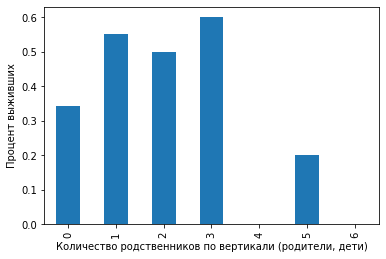

In [ ]:
gr = df.groupby(['Parch'])[['Survived']].mean().reset_index()
gr['Survived'].plot(kind='bar');
plt.xlabel('Количество родственников по вертикали (родители, дети)');
plt.ylabel('Процент выживших');

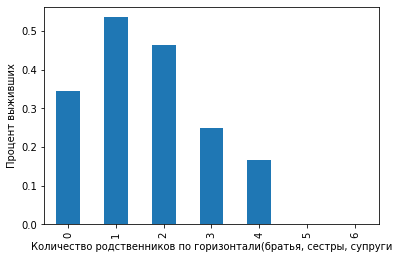

In [ ]:
gr = df.groupby(['SibSp'])[['Survived']].mean().reset_index()
gr['Survived'].plot(kind='bar');
plt.xlabel('Количество родственников по горизонтали(братья, сестры, супруги');
plt.ylabel('Процент выживших');

Добавим признак с общим количесвтом родственников на корабле и посмотрим, как он влияет на выживаемость.
Так же приходит в голову добавить признак "одиночества" пассажира 

In [ ]:
# Общее количество родственноков: SibSp (братья и сестры / супруги) Parch (родители/дети)
df['Relatives'] = df['SibSp'] + df['Parch'] 
# Одинокий ли человек
df['IsAlone'] = df['Relatives'].apply(lambda x: 1 if x==0 else 0)

Видим, что люди с маленьким количеством родственников (от 1 до 3) выживали существенно чаще чем люди с большим количеством родственников. При этом, отсутсвие родственников также не слишком хорошо помогало спастись.

In [ ]:
# Мало родственников
df['NotMuchRelatives'] = df['Relatives'].apply(lambda x: 0 if x in [0, 4, 5, 6, 7, 8] else 1)

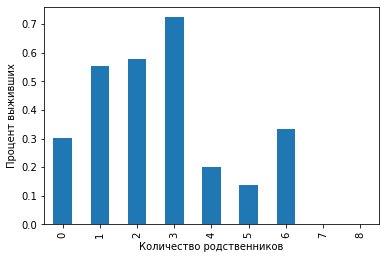

In [ ]:
gr = df.groupby(['Relatives'])[['Survived']].mean().reset_index()
gr['Survived'].plot(kind='bar');
plt.xlabel('Количество родственников');
plt.ylabel('Процент выживших');

In [ ]:
X = df[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked','SibSp', 'Parch', 'Relatives', 'IsAlone']]
y = df['Survived']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
tree = DecisionTreeClassifier(max_depth=5, random_state=17) 
tree.fit(X, y)
scores = cross_val_score(tree, X, y, cv=kf, scoring='f1')
print("Точность на трейне: \n{}".format(f1_score(tree.predict(X), y)))
print("Точность на кросс-валидации: \n{}".format(scores.mean()))

permutation = PermutationImportance(tree,  scoring ='f1', n_iter=5, random_state=17).fit(X, y)
eli5.show_weights(permutation, feature_names=X.columns.tolist())

Точность на трейне: 
0.7795031055900622
Точность на кросс-валидации: 
0.7417911439420856


Weight,Feature
0.3370 ± 0.0191,Sex
0.0783 ± 0.0024,Pclass
0.0657 ± 0.0225,Age
0.0507 ± 0.0157,Fare
0.0195 ± 0.0056,Parch
0.0085 ± 0.0027,SibSp
0.0012 ± 0.0000,Relatives
0 ± 0.0000,IsAlone
0 ± 0.0000,Embarked


In [ ]:
X = df[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked','SibSp', 'Parch', 'Relatives', 'IsAlone', 'NotMuchRelatives']]
y = df['Survived']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
tree = DecisionTreeClassifier(max_depth=5, random_state=17) 
tree.fit(X, y)
scores = cross_val_score(tree, X, y, cv=kf, scoring='f1')
print("Точность на трейне: \n{}".format(f1_score(tree.predict(X), y)))
print("Точность на кросс-валидации: \n{}".format(scores.mean()))

permutation = PermutationImportance(tree,  scoring ='f1', n_iter=5, random_state=17).fit(X, y)
eli5.show_weights(permutation, feature_names=X.columns.tolist())

Точность на трейне: 
0.7795031055900622
Точность на кросс-валидации: 
0.7429676145303208


Weight,Feature
0.3375 ± 0.0254,Sex
0.0704 ± 0.0289,Age
0.0641 ± 0.0110,Pclass
0.0408 ± 0.0124,Fare
0.0270 ± 0.0065,Relatives
0.0017 ± 0.0024,Parch
0 ± 0.0000,NotMuchRelatives
0 ± 0.0000,IsAlone
0 ± 0.0000,SibSp
0 ± 0.0000,Embarked


**Какие признаки оставить?**
Попробуем оставить самые значимые признаки, построить модель по ним посмотреть метрики качества. Самые значимые и устойчивые значения имеют признаки Sex, Age, Pclass, Fare и Relatives

**Вопрос:**
Несмотря на то, что значение для  признака Parch > 0, мы не будем его использовать. Подумайте, почему


In [ ]:
X = df[['Pclass', 'Sex', 'Age', 'Fare','Relatives']]
y = df['Survived']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
tree = DecisionTreeClassifier(max_depth=5, random_state=17) 
tree.fit(X, y)
scores = cross_val_score(tree, X, y, cv=kf, scoring='f1')
print("Точность на трейне: \n{}".format(f1_score(tree.predict(X), y)))
print("Точность на кросс-валидации: \n{}".format(scores.mean()))

permutation = PermutationImportance(tree,  scoring ='f1', n_iter=5, random_state=17).fit(X, y)
eli5.show_weights(permutation, feature_names=X.columns.tolist())

Точность на трейне: 
0.7795031055900622
Точность на кросс-валидации: 
0.7427679553770182


Weight,Feature
0.3356 ± 0.0254,Sex
0.0763 ± 0.0244,Age
0.0626 ± 0.0094,Pclass
0.0531 ± 0.0082,Fare
0.0296 ± 0.0043,Relatives


Отлично, точность модели на кросс-валидации улучшилась.

Но мы также можем пойти другим путем. Сгенерированные признаки **Relatives**, **IsAlone**, **NotMuchRelatives** являются производными от **SibSp**, **Parch**  и в каком-то смысле несут похожую информацию, только в ином представлении. Что, если какой-то один или несколько из них могут лучше всего передать информацию, необходимую для модели?

Попробуем построить модель только на этих признаках и посмотреть их важность.

In [ ]:
X = df[['SibSp', 'Parch', 'Relatives', 'IsAlone', 'NotMuchRelatives']]
y = df['Survived']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
tree = DecisionTreeClassifier(max_depth=5, random_state=17) 
tree.fit(X, y)
scores = cross_val_score(tree, X, y, cv=kf, scoring='f1')
print("Точность на трейне: \n{}".format(f1_score(tree.predict(X), y)))
print("Точность на кросс-валидации: \n{}".format(scores.mean()))

permutation = PermutationImportance(tree,  scoring ='f1', n_iter=5, random_state=17).fit(X, y)
eli5.show_weights(permutation, feature_names=X.columns.tolist())

Точность на трейне: 
0.5363489499192245
Точность на кросс-валидации: 
0.48878183222765104


Weight,Feature
0.1724 ± 0.0345,NotMuchRelatives
0.0163 ± 0.0063,Relatives
0.0141 ± 0.0112,SibSp
0.0028 ± 0.0052,Parch
0 ± 0.0000,IsAlone


Сейчас нас не интересуют метрики точности самой модели, т.к. понятное дело, из-за того, что мы исключили все остальные признаки, она стала очень неточной. Нам интересна таблица с влиянием оставшихся признаков на модель.

Как видно из таблицы, самыми важным является признак **NotMuchRelatives**, который с большим отрывом обгоняет **Relatives**.
Можно попробовать оставить только самый важный или два самых важных в основной модели. Посмотрим на ее качество.

In [ ]:
X = df[['Pclass', 'Sex', 'Age', 'Fare', 'NotMuchRelatives']]
y = df['Survived']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
tree = DecisionTreeClassifier(max_depth=5, random_state=17) 
tree.fit(X, y)
scores = cross_val_score(tree, X, y, cv=kf, scoring='f1')
print("Точность на трейне: \n{}".format(f1_score(tree.predict(X), y)))
print("Точность на кросс-валидации: \n{}".format(scores.mean()))

permutation = PermutationImportance(tree,  scoring ='f1', n_iter=5, random_state=17).fit(X, y)
eli5.show_weights(permutation, feature_names=X.columns.tolist())

Точность на трейне: 
0.7832817337461301
Точность на кросс-валидации: 
0.7458773402141914


Weight,Feature
0.3443 ± 0.0251,Sex
0.1661 ± 0.0161,Pclass
0.0809 ± 0.0077,Fare
0.0646 ± 0.0210,Age
0.0200 ± 0.0032,NotMuchRelatives


Нам удалось неплохо увеличить точность! 

### <center> 2. Моделируем взаимодействия признаков

Иногда влияние признака на целевую переменную по крайней мере частично зависит от другого признака. Например, представьте себе простой пример с кофе, где у нас два бинарных признака — наличие сахара (**sugar**) и было ли выполнено перемешивание (**stirred**) — и требуется предсказать, сладкий ли кофе на вкус. Просто положив сахар в кофе (**sugar=1**, **stirred=0**), мы не сделаем вкус кофе сладким (весь сахар на дне!), а одно перемешивание кофе без добавления сахара (**sugar=0**, **stirred=1**) не сделает его сладким. Как раз наоборот, именно взаимодействие брошенного в кофе сахара и перемешивания кофе (**sugar=1**, **stirred=1**) сделает вкус кофе сладким. 

Влияния сахара и перемешивания на сладость зависят друг от друга. В этом случае мы говорим, что существует эффект взаимодействия между признаками **sugar** И **stirred**.
$$\widehat{y} = \widehat{\beta_{0}} + \widehat{\beta_{1}}x_{1} + \widehat{\beta_{2}}x_{2}+ \widehat{\beta_{3}}x_{1}x_{2} + \epsilon$$


Попробуем воссоздать такое взаимодействие с признаками с помощью библиотеки **sklearn.**

**Полиномиальное преобразование** генерирует полиномиальную комбинуцию признаков указанной степени полинома.

Например, есть матрица из двух признаков a и b: 

$$[a, b]$$

Полиномиальная комбинация призаков **2-й** степени будет выглядеть так: 
$$[1, a, b, a^2, ab, b^2]$$
Полиномиальная комбинация призаков **3-й** степени будет выглядеть так: 
$$[1, a, b, a^2, ab, b^2, a^3, a^2b, ab^2, b3]$$
И так далее ...

**Фактически мы получили 2 дополнительных вида признаков:**

1. Перемножение признаков друг с другой - ***взаимодействие признаков***
2. Возведение признака в степень - ***нелинейность***

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
X = np.arange(6).reshape(3, 2)
X

array([[0, 1],
       [2, 3],
       [4, 5]])

In [ ]:
# Полином 2-й степени 
poly = PolynomialFeatures(degree=2)
poly.fit_transform(X)

array([[ 1.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  2.,  3.,  4.,  6.,  9.],
       [ 1.,  4.,  5., 16., 20., 25.]])

In [ ]:
# Полином 3-й степени 
poly = PolynomialFeatures(degree=3)
poly.fit_transform(X)

array([[  1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.],
       [  1.,   2.,   3.,   4.,   6.,   9.,   8.,  12.,  18.,  27.],
       [  1.,   4.,   5.,  16.,  20.,  25.,  64.,  80., 100., 125.]])

In [ ]:
# Оставляем только взаимодействие признаков
poly = PolynomialFeatures(degree=2, interaction_only=True)
poly.fit_transform(X)

array([[ 1.,  0.,  1.,  0.],
       [ 1.,  2.,  3.,  6.],
       [ 1.,  4.,  5., 20.]])

In [ ]:
# Убираем свободный член полинома
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly.fit_transform(X)

array([[ 0.,  1.,  0.],
       [ 2.,  3.,  6.],
       [ 4.,  5., 20.]])

**Рассмотрим как это раотает на реальном примере**

In [ ]:
from sklearn.datasets import load_boston

In [ ]:
boston = load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['PRICE'] =  boston.target
df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


**BaseLine**

In [ ]:
features = df[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX','PTRATIO', 'B', 'LSTAT']]
target = df['PRICE']


In [ ]:
lr = LinearRegression()
lr.fit(features, target)
prediction = lr.predict(features)

print('MAE: ', mean_absolute_error(target, prediction))
print('_'*50)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
print('Cross-val MAE: ', -cross_val_score(lr, X=features, y=target, cv=kf, scoring="neg_mean_absolute_error").mean())


MAE:  3.2708628109003164
__________________________________________________
Cross-val MAE:  3.388460472275863


**Взаимодействие признаков**

Выберем 6 признаков и добавим фичи как взаимодействия признаков

In [ ]:
features_6 = df[['CRIM', 'RM', 'AGE', 'B', 'LSTAT', 'DIS']]

# Добавляем взаимодействия признаков, получаем 41 признаков вместо изначальных 13
interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
features_interaction = interaction.fit_transform(features_6)
features_interaction.shape

(506, 41)

In [ ]:
interaction.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x0 x5',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x1 x5',
 'x2 x3',
 'x2 x4',
 'x2 x5',
 'x3 x4',
 'x3 x5',
 'x4 x5',
 'x0 x1 x2',
 'x0 x1 x3',
 'x0 x1 x4',
 'x0 x1 x5',
 'x0 x2 x3',
 'x0 x2 x4',
 'x0 x2 x5',
 'x0 x3 x4',
 'x0 x3 x5',
 'x0 x4 x5',
 'x1 x2 x3',
 'x1 x2 x4',
 'x1 x2 x5',
 'x1 x3 x4',
 'x1 x3 x5',
 'x1 x4 x5',
 'x2 x3 x4',
 'x2 x3 x5',
 'x2 x4 x5',
 'x3 x4 x5']

Метрика **MAE** с новыми фичами немного улучшилась

In [ ]:
interaction_lr = LinearRegression()
interaction_lr.fit(features_interaction, target)
prediction = interaction_lr.predict(features_interaction)

print('MAE: ', mean_absolute_error(prediction, target))
print('_'*50)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print('Cross-val MAE: ', -cross_val_score(interaction_lr, X=features_interaction, y=target, cv=kf, scoring="neg_mean_absolute_error").mean())


MAE:  2.599099893105942
__________________________________________________
Cross-val MAE:  3.241646783041806


При применении полиномиального преобразования только на 6 признаках качество модели улучшилось. Возникает вполне логичная мылсь: почему бы не проделать такое преобразования на всех 13 исходных признаках?

Посмотрим качество модели, если сгенерируем полиномиальные признаки для всех исодных признаков

In [ ]:
features = df[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX','PTRATIO', 'B', 'LSTAT']]

# Добавляем взаимодействия признаков, получаем 377 признаков вместо изначальных 13
interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
features_interaction = interaction.fit_transform(features)
features_interaction.shape

(506, 377)

In [ ]:
interaction_lr = LinearRegression()
interaction_lr.fit(features_interaction, target)
prediction = interaction_lr.predict(features_interaction)

print('MAE: ', mean_absolute_error(prediction, target))
print('_'*50)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print('Cross-val  MAE: ', -cross_val_score(interaction_lr, X=features_interaction, y=target, cv=kf, scoring="neg_mean_absolute_error").mean())


MAE:  0.8942150012326114
__________________________________________________
Cross-val  MAE:  14.089764392498509


Видим очень сильное переобучение!

**Почему так происходит?**

Размерность признаков очень большая, мы получили матрицу размера 506 на 377. Для такого большого количества фич у нас слишком мало данных.

Для иллюстрации этого эффекта давайте "сломаем" хороший пример, в котором мы генерировали полиномиальные комбинации для 6 фич. Давайте уменьшим количество наблюдений до 100 и посмотрим, будет ли переобучение при этом.

In [ ]:
interaction_lr = LinearRegression()
interaction_lr.fit(features_interaction[:100], target[:100])
prediction = interaction_lr.predict(features_interaction[:100])

print('MAE: ', mean_absolute_error(prediction, target[:100]))
print('_'*50)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print('Cross-val MAE: ', -cross_val_score(interaction_lr, X=features_interaction[:100], y=target[:100], cv=kf, scoring="neg_mean_absolute_error").mean())


MAE:  2.6792967844357917e-12
__________________________________________________
Cross-val MAE:  33.82971796946204


Видим переобучение. Что изменилось? Мы имеем размерность данных 100 на 41, данных всего лишь в 2,5 раза больше чем признаков, этого не достаточно для хорошего обучения.

При этом, если мы используем только 6 признаков без преобразования и 100 строк данных, переобучение не происходит, т.к. мы соблюдаем адекватное соотношение ***признаки-наблюдения.***

In [ ]:
interaction_lr = LinearRegression()
interaction_lr.fit(features_6[:100], target[:100])
prediction = interaction_lr.predict(features_6[:100])

print('MAE: ', mean_absolute_error(prediction, target[:100]))
print('_'*50)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print('Cross-val MAE: ', -cross_val_score(interaction_lr, X=features_6[:100], y=target[:100], cv=kf, scoring="neg_mean_absolute_error").mean())


MAE:  1.70294863957018
__________________________________________________
Cross-val MAE:  1.9685866428180212


### <center> 3. Моделируем эффект нелинейности

До сих пор мы обсуждали моделирование только ***линейных связей***. Примером линейной связи может служить количество этажей здания и его высота. В линейной регрессии мы исходим из того, что эффект количества этажей и высоты здания примерно постоянен, а это означает, что 20-этажное здание будет примерно в два раза выше, чем 10-этажное, которое будет примерно в два раза выше, чем 5-этажное здание.

Однако многие представляющие интерес связи не являются строго линейными. Нередко требуется смоделировать **нелинейную связь** — например, связь между количеством часов, которые учащийся тратит на учебу, и оценкой, которую он получает за контрольную работу. Интуитивно мы можем себе представить, что в оценках между учащимися, которые учились в течение одного часа, и учащимися, которые вообще не учились, есть большая разница. Вместе с тем существует гораздо меньшая разница в оценках между учащимся, который учился в течение 99 часов, и учащимся, который учился в течение 100 часов. Влияние одного часа учебы на итоговую оценку учащегося уменьшается по мере увеличения количества часов.

Еще один пример нелинейности - из экономики, это так называемый **Закон убывающей предельной полезности**. Он гласит, что с каждой дополнительной единицей товара его предельная полезность падает. Проиллюстрируем на простом примере. Вы голодны и съедаете бутерброд. Первый будетерброд съедается с большим удовольствием, да и второй неплохо идет. По мере насыщения, каждый следующий бутерброд уже не представляет такой ценности и, скажем, 20 уже уже вряд ли будет вас радовать :)


**Полиномиальная регрессия** — это расширение линейной регрессии, позволяющее моделировать нелинейные связи. Для того чтобы создать полиномиальную регрессию, следует конвертировать линейную функцию
$$\widehat{y} = \widehat{\beta_{0}} + \widehat{\beta_{1}}x_{1} + \widehat{\beta_{2}}x_1^2 + ... + \epsilon$$

Мы используем тот же преобразователь **PolynomialFeatures** из **sklearn**, только теперь мы оставляем не только перемножение признаков друг с другом, но и возведение их в степень

In [ ]:
non_linear = PolynomialFeatures(degree=3, include_bias=False, interaction_only=False)
features_non_linear = non_linear.fit_transform(features_6)
features_non_linear.shape

(506, 83)

In [ ]:
non_linear.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x0 x5',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x1 x5',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x2 x5',
 'x3^2',
 'x3 x4',
 'x3 x5',
 'x4^2',
 'x4 x5',
 'x5^2',
 'x0^3',
 'x0^2 x1',
 'x0^2 x2',
 'x0^2 x3',
 'x0^2 x4',
 'x0^2 x5',
 'x0 x1^2',
 'x0 x1 x2',
 'x0 x1 x3',
 'x0 x1 x4',
 'x0 x1 x5',
 'x0 x2^2',
 'x0 x2 x3',
 'x0 x2 x4',
 'x0 x2 x5',
 'x0 x3^2',
 'x0 x3 x4',
 'x0 x3 x5',
 'x0 x4^2',
 'x0 x4 x5',
 'x0 x5^2',
 'x1^3',
 'x1^2 x2',
 'x1^2 x3',
 'x1^2 x4',
 'x1^2 x5',
 'x1 x2^2',
 'x1 x2 x3',
 'x1 x2 x4',
 'x1 x2 x5',
 'x1 x3^2',
 'x1 x3 x4',
 'x1 x3 x5',
 'x1 x4^2',
 'x1 x4 x5',
 'x1 x5^2',
 'x2^3',
 'x2^2 x3',
 'x2^2 x4',
 'x2^2 x5',
 'x2 x3^2',
 'x2 x3 x4',
 'x2 x3 x5',
 'x2 x4^2',
 'x2 x4 x5',
 'x2 x5^2',
 'x3^3',
 'x3^2 x4',
 'x3^2 x5',
 'x3 x4^2',
 'x3 x4 x5',
 'x3 x5^2',
 'x4^3',
 'x4^2 x5',
 'x4 x5^2',
 'x5^3']

Как видим, применение данной техники к 6 признакам привело к переобучению

In [ ]:
non_linear_lr = LinearRegression()
non_linear_lr.fit(features_non_linear, target)
prediction = non_linear_lr.predict(features_non_linear)

print('MAE: ', mean_absolute_error(prediction, target))
print('_'*50)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print('Cross-val MAE: ', -cross_val_score(non_linear_lr, X=features_non_linear, y=target, cv=kf, scoring="neg_mean_absolute_error").mean())

MAE:  2.038249081327906
__________________________________________________
Cross-val MAE:  4.038559536458368


### <center> 4. Временные признаки

**Наиболее часты манипуляции с датой/временем:**
    
1. Выделение компонентов даты/времени: сезонов, месяцев, дня недели, часа и т.д.
2. Выделение события: "выходной день", "праздничный день" и т.д.
3. Отображение на круг (аналогия с наручными часами)    

**Отображение на круг**

Данное преобразование позволяет отразить физический смылс времени и близости временных промежутков друг к другу, что мы видим на круглом циферблате ручных часов и чего нет при 24-х часовом формате отображения времени. 

- К примеру, мы понимаем, что между 23:00 часами и полночью (00:00) не большая разница во времени. Однако, если рассматривать 24-х часовой формат, то расстояние между ними 23 единицы. 

- 12-и часовой формат нам так же не сильно подходит, т.к. все еще остается большая разница между 12 часами и 1 часом. К тому же в при таком формате мы теряем о периоде суток - нет разницы между 1 часом дня или 1 часом ночи. 

Решить это проблему помогут периодичные функции синус и косинус. Достаточно сделать вот такbt преобразования:
$$cos\_hour = Cos(\frac{hour *2*\pi}{max(hour)}) =  Cos(\frac{hour *2*\pi}{24})$$
 
$$sin\_hour = Sin(\frac{hour *2*\pi}{max(hour)}) =  Sin(\frac{hour *2*\pi}{24})$$

<img src='https://github.com/MalikaL17/course_materials/blob/main/img/feature_eng_1.PNG?raw=true'>
<img src='https://github.com/MalikaL17/course_materials/blob/main/img/feature_eng_2.PNG?raw=true'>

In [ ]:
import math 

In [ ]:
math.cos(1)

0.5403023058681398

In [ ]:
df = pd.DataFrame({'hour':[i for i in range(24)]})
df.head()

,hour
0,0
1,1
2,2
3,3
4,4


In [ ]:
df['hour_cos'] = df['hour'].apply(lambda x: math.cos(x * 2 * math.pi / 24))
df['hour_sin'] =  df['hour'].apply(lambda x: math.sin(x * 2 * math.pi / 24))
df.head()

,hour,hour_cos,hour_sin
0,0,1.000000,0.000000
1,1,0.965926,0.258819
2,2,0.866025,0.500000
3,3,0.707107,0.707107
4,4,0.500000,0.866025


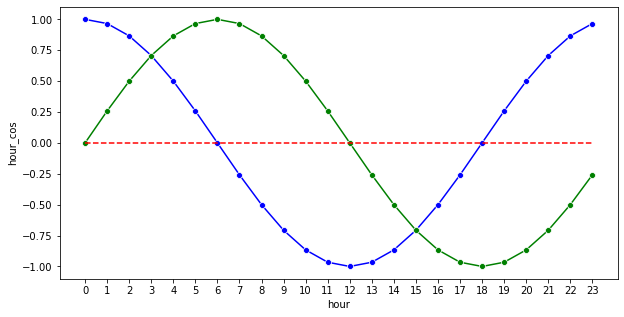

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(x='hour', y='hour_cos', data=df, color='blue', marker='o');
sns.lineplot(x='hour', y='hour_sin', data=df, color='green', marker='o')
sns.lineplot(x='hour', y=[0]*24, data=df, color='r', linestyle='dashed',)
plt.xticks(df['hour']);

Теперь видно, что расстояние между 23:00 и 00:00 стало намного меньше, при этом сохранилось различие между дневными и ночными часами суток 